In [80]:
# autoreload to reload modules when they change
%load_ext autoreload
%autoreload 2

import rollout
from torch import optim
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

from tqdm import trange

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
import os
import numpy as np
import seaborn as sns
def get_subdirectories(directory):
    return [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]


def get_training_curves():
    dir_list = get_subdirectories('data/dual_task/')
    tc = []
    for d in dir_list:
        tc.append(np.load('data/dual_task/' + d + '/results.pkl', allow_pickle=True))
    return tc 

tcs = get_training_curves()

/var/folders/23/ryhrv04s5_q_zzrtln1zy1gc0000gn/T/ipykernel_30549/1018622173.py:3: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(np.arange(n_epochs),)


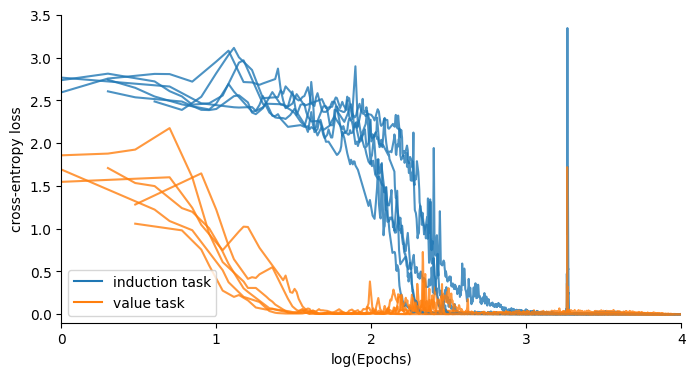

In [74]:
def plot_training_curves(ax, tc):
    n_epochs = len(tc["test_losses"])
    x = np.log10(np.arange(n_epochs),)
    induction_idx, value_idx = np.where(np.array(tc["test_task"]) == 10)[0], np.where(np.array(tc["test_task"]) == 11)[0]
    ax.plot(x[induction_idx], np.array(tc["test_losses"])[induction_idx], c="C0", alpha=0.8)
    ax.plot(x[value_idx], np.array(tc["test_losses"])[value_idx], c="C1", alpha=0.8)
    return ax

#plot_training_curves(tcs[8])

bad_models_idx = np.array([0, 1, 3])
good_models_idx = np.array([2, 4, 5, 6, 7, 8])

fig, ax = plt.subplots(figsize=(8, 4))
for model in good_models_idx:
    ax = plot_training_curves(ax, tcs[model])
ax.set_xlabel("log(Epochs)")
ax.set_ylabel("cross-entropy loss")
ax.plot([0, 0], [0, 0], c="C0", label="induction task")
ax.plot([0, 0], [0, 0], c="C1", label="value task")
ax.legend()
ax.set_xlim(0, 4)
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_ylim(-0.1, 3.5)
sns.despine()


In [101]:
good_models_idx = np.array([2, 4, 5, 6, 7, 8])
dir_list = get_subdirectories('data/dual_task/')

good_models = [torch.load('data/dual_task/' + dir_list[i] + '/model.pt') for i in good_models_idx]
for model in good_models:
    model.eval()

/var/folders/23/ryhrv04s5_q_zzrtln1zy1gc0000gn/T/ipykernel_30549/230999687.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  good_models = [torch.load('data/dual_task/' + 

In [102]:
n_tokens = 10
max_sequence = 6
dataset = rollout.dataset.InductionValueDataset(n_tokens, max_sequence)

In [103]:
value_samples = dataset.generate_batch(batch_size=1000, type="test", task="value")

In [135]:
samp_i = 0

In [147]:
X_value[0]

tensor([11,  9,  5,  1,  7,  2,  9])

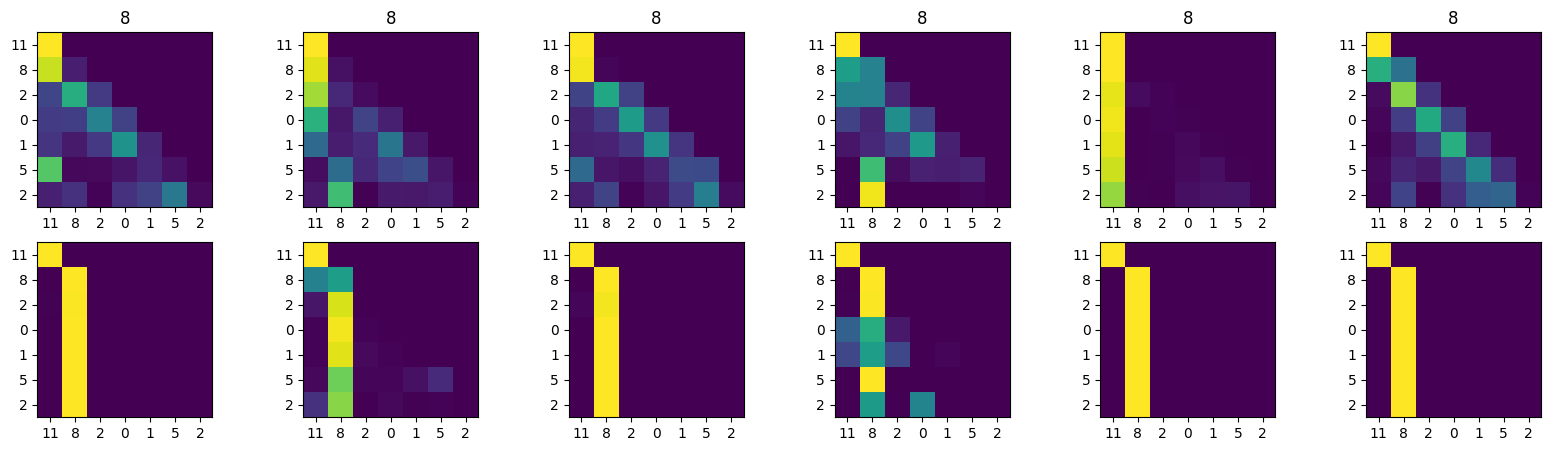

In [151]:
samp_i += 1
X_value = value_samples[0][samp_i, :].unsqueeze(0)
X_induction = X_value.clone()
X_induction[0][0] = 10

value_activations = [good_models[i]._fwd_internal(X_value, return_weights=True, return_residuals=True) for i in range(len(good_models))]
induction_activations = [good_models[i]._fwd_internal(X_induction, return_weights=True, return_residuals=True) for i in range(len(good_models))]

def plot_activation(activation, samp, ax):
    ax.imshow(activation.squeeze(0).detach().numpy())
    samp = samp.squeeze(0).detach().numpy()
    ax.set_xticks(np.arange(0, 7), labels=samp)
    ax.set_yticks(np.arange(0, 7), labels=samp)

fig, ax = plt.subplots(2, 6, figsize=(20, 5))
for j in range(6):
    for k in range(2):
        plot_activation(value_activations[j][1][k], X_value, ax[k, j])
    pred = np.argmax(good_models[j](X_value).detach().numpy())
    ax[0, j].set_title(pred)



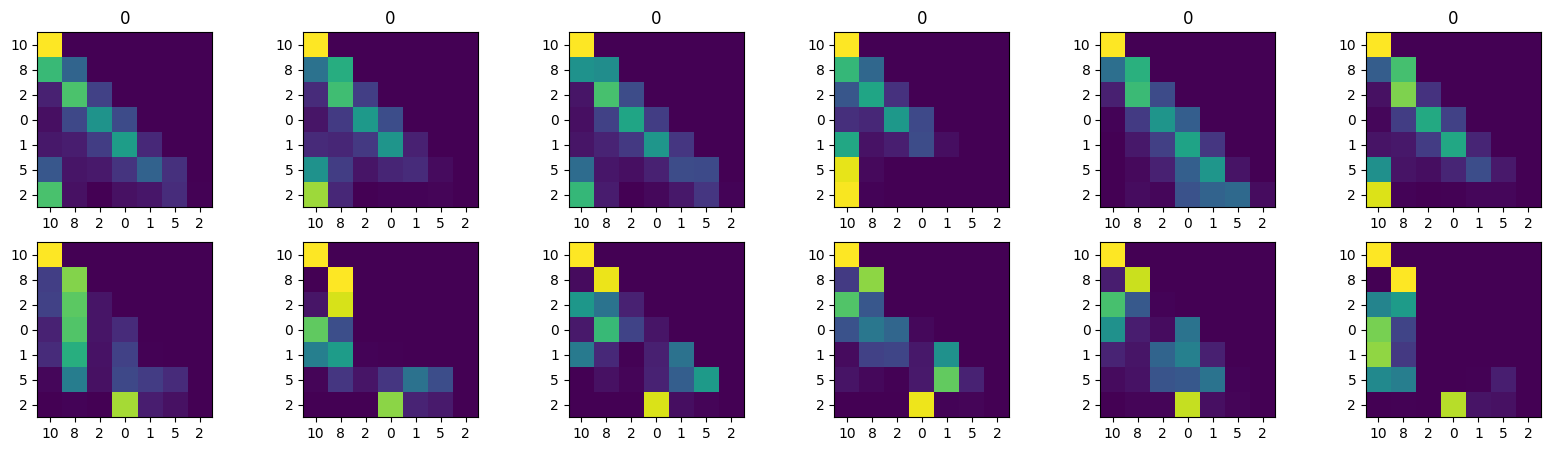

In [152]:
fig, ax = plt.subplots(2, 6, figsize=(20, 5))
for j in range(6):
    for k in range(2):
        plot_activation(induction_activations[j][1][k], X_induction, ax[k, j])
    pred = np.argmax(good_models[j](X_induction).detach().numpy())
    ax[0, j].set_title(pred)